# FL Tripadvisor Review Analysis and Classification

**My primary goals here are two-fold:**

   **1. To explore the review scores and textual content of these Florida Hotel TripAdvisor Reviews to find trends and common words**
    
   **2. To build a classification model based on the review scores of the reviews in order to classify future textual data and feedback according to a predicted review score**

# Loading Packages and Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sns.set_style('whitegrid')

In [3]:
df=pd.read_csv(r"C:\Users\Test\Documents\FLTextRawData.csv")


C:\Users\Test\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.head()


,Property Id,Date_of_stay,Review,Rating,Chain Segment,Walkability,Avg Value Rating,Property Type,Location Type
0,1691,7/31/2022,"This hotel is very dirty, the doors are not pr...",1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban
1,1691,6/30/2022,This place is a flop house! Do not stay here! ...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban
2,1691,9/30/2022,Very disappointed with quality and cleanliness...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban
3,1691,6/30/2022,"Weekly rate, the room was accommodating, frien...",4.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban
4,1691,9/30/2022,The high quality stands I was used to in La Qu...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban


# Data Cleaning

Here, Null values are removed so that we have no missing data

In [5]:
df.isna().sum()

Property Id          0
Date_of_stay        86
Review               3
Rating              86
Chain Segment        0
Walkability          0
Avg Value Rating     0
Property Type        0
Location Type        0
dtype: int64

In [6]:
df=df.dropna()

In [7]:
df.isna().sum()

Property Id         0
Date_of_stay        0
Review              0
Rating              0
Chain Segment       0
Walkability         0
Avg Value Rating    0
Property Type       0
Location Type       0
dtype: int64

# Data Exploration

We examine the counts for each review score, below we can see an imbalance which may complicate future model-building

Text(0.5, 1.0, 'Review Count by Rating')

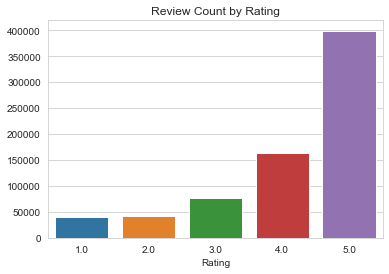

In [8]:
grouped = df.groupby('Rating')['Rating'].count()
sns.barplot(x = grouped.index, y = grouped.values).set_title('Review Count by Rating')

In [9]:
df['Date_of_stay'] = pd.to_datetime(df.Date_of_stay)
df['Year of Review'] = df['Date_of_stay'].dt.year 


In [10]:
df.head()

,Property Id,Date_of_stay,Review,Rating,Chain Segment,Walkability,Avg Value Rating,Property Type,Location Type,Year of Review
0,1691,2022-07-31,"This hotel is very dirty, the doors are not pr...",1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022
1,1691,2022-06-30,This place is a flop house! Do not stay here! ...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022
2,1691,2022-09-30,Very disappointed with quality and cleanliness...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022
3,1691,2022-06-30,"Weekly rate, the room was accommodating, frien...",4.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022
4,1691,2022-09-30,The high quality stands I was used to in La Qu...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022


Text(0.5, 1.0, 'Review Count by Year')

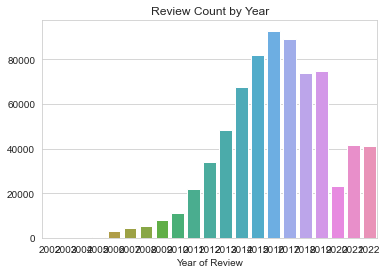

In [11]:
grouped2 = df.groupby('Year of Review')['Year of Review'].count()
sns.barplot(x = grouped2.index, y = grouped2.values).set_title('Review Count by Year')

In [12]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'

df['new_rating'] = df['Rating'].apply(new_rating)

**Our Data Is imbalanced, so we will combine several categories to achieve balance. A score of 1-2 will be labeled 'poor', 3-4: 'average', and a score fo 5: 'excellent'.**

Text(0.5, 1.0, 'Grouped Review Count by Rating')

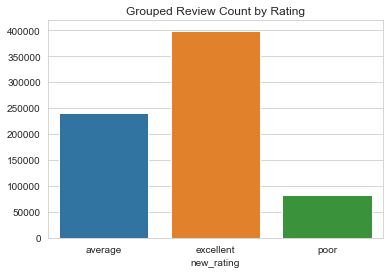

In [13]:
new_rating_grouped = df.groupby('new_rating')['Rating'].count()
new_rating_grouped
sns.barplot(x = new_rating_grouped.index, y = new_rating_grouped.values).set_title('Grouped Review Count by Rating')

**While still imbalanced, this imbalance is still less severe than our initial review scores and is better fit for our mdoel. The classification into a textual label makes the classification more meaningful and actionable as well from a business standpoint.**

Text(0.5, 1.0, 'Word Count by Review')

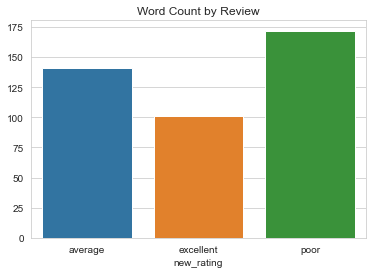

In [14]:
df['words'] = [x.split() for x in df['Review']]
df['word_count'] = [len(x) for x in df['words']]

grouped_rating = df.groupby('new_rating')['word_count'].mean()
sns.barplot(x = grouped_rating.index, y = grouped_rating.values).set_title('Word Count by Review')

**Note: The best reviews have the lowest word counts**

# Preparing and Tokenizing the Textual Data

Following the basic data exploration, we can then take a deeper look into the textual content of the reviews, we must first prepare this data by removing stopwords and common irrelevant terms that may cloud our data (i.e. 'review', 'hotel', 'stay')

In [15]:
sw = stopwords.words('english')

In [16]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
def doc_preparer(doc, stop_words=sw):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [18]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Test\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Test\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
df['tokenized'] = df['Review'].apply(doc_preparer)

In [20]:
df.head()

,Property Id,Date_of_stay,Review,Rating,Chain Segment,Walkability,Avg Value Rating,Property Type,Location Type,Year of Review,new_rating,words,word_count,tokenized
0,1691,2022-07-31,"This hotel is very dirty, the doors are not pr...",1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022,poor,"[This, hotel, is, very, dirty,, the, doors, ar...",66,hotel dirty door properly seal bug get room sw...
1,1691,2022-06-30,This place is a flop house! Do not stay here! ...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022,poor,"[This, place, is, a, flop, house!, Do, not, st...",49,place flop house stay could see daylight aroun...
2,1691,2022-09-30,Very disappointed with quality and cleanliness...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022,poor,"[Very, disappointed, with, quality, and, clean...",73,disappointed quality cleanliness room hotel ol...
3,1691,2022-06-30,"Weekly rate, the room was accommodating, frien...",4.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022,average,"[Weekly, rate,, the, room, was, accommodating,...",79,weekly rate room accommodate friendly staff ob...
4,1691,2022-09-30,The high quality stands I was used to in La Qu...,1.0,Upper Midscale,Car recommended,1.5,Limited-Service Hotel,Mid-sized City - Urban,2022,poor,"[The, high, quality, stands, I, was, used, to,...",62,high quality stand use la quinta hotel miss en...


# Word Cloud Creation

**We will now generate a word cloud to see the msot common words in reviews for each elvel of rating based on our new ratings**

In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.add("hotel")
stopwords.add("review")
stopwords.add("stay")
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

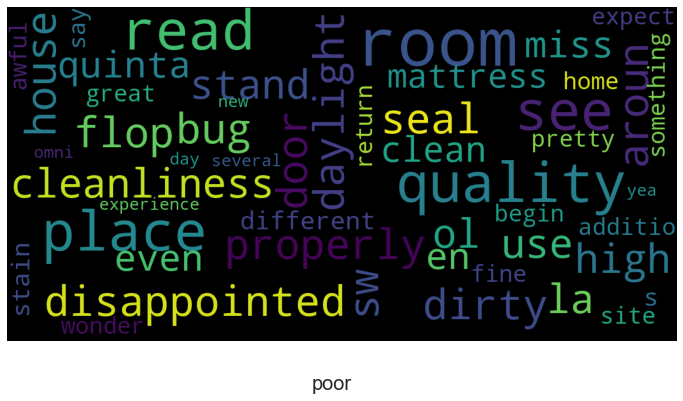

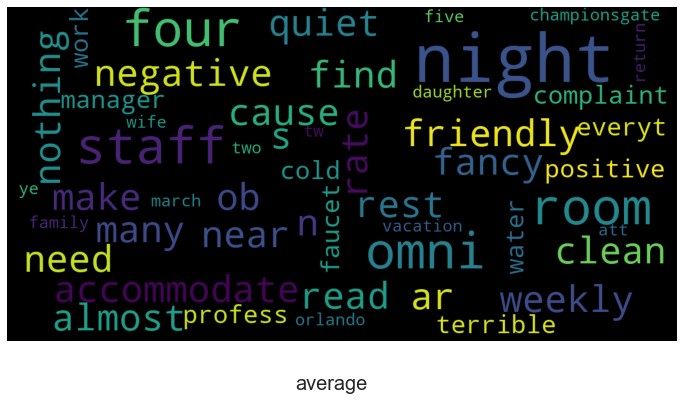

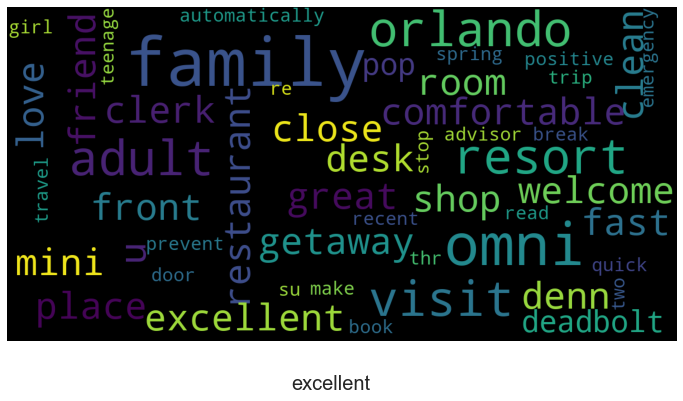

In [42]:
for rating in list(df['new_rating'].unique()):
    show_wordcloud(df[df['new_rating']==rating]['tokenized'], title=rating)

# Interpretation

From these wordclouds, we can see that poor reviews typically mention 'room', 'cleanliness', and other words related to sanitary concerns such as 'dirt' and 'bug'. Excellent reviews in contrast mention 'restaraunt', 'comfortable', 'welcome', 'friend' and 'room'. This may imply that the factors most influencing negative reviews are room quality and cleanliness whereas excellent reviews are influenced by these faactors as well as the friendliness and welcoming nature of the hotel staff and nearby (or integrated) restaurants.

# Classification Model

Now that the data has been explored, I can create a classification model to predict the review score based on the tokenized text. As the Ratings 1-5 data was imbalanced, we will use the more balanced groupings of Score 1-2: 'poor', 3-4: 'average' and 5: 'excellent'

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df['tokenized']
y = df['new_rating_value']

In [36]:
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

x_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104, test_size=0.3, shuffle=True)

pipe_lr.fit(x_train,y_train)


C:\Users\Test\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])

In [38]:
pipe_lr.score(X_test,y_test)


0.7185607475773383

**Thus my model can predict a review's score based on tokenized text with 71.86% accuracy**